In [62]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import pandas as pd
from datasets import ClassLabel
import psutil
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import numpy as np
from IPython.display import clear_output

import src.model.fasttext as fasttext
import src.model.tokenizer as tokenizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
ds = load_dataset("elalber2000/stop-slop-data")["train"]
ds = ds.rename_columns({
    "content": "text",
})

def binarize(example):
    example['label'] = {"Non-Slop": 0, "Slop": 1}[example['slop']]
    return example

ds = ds.map(binarize)

features = ds.features.copy()
features["label"] = ClassLabel(names=["Non-Slop", "Slop"])
ds = ds.cast(features)

In [64]:
splits = ds.train_test_split(
    test_size=0.2,
    stratify_by_column="label",
    seed=42
)
train_ds, val_ds = splits["train"], splits["test"]

In [65]:
# Memory Availability

mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**2):.2f} MB")
print(f"Total memory: {mem.total / (1024**2):.2f} MB")
print(f"Used memory: {(mem.total - mem.available) / (1024**2):.2f} MB")

Available memory: 1436.87 MB
Total memory: 2987.68 MB
Used memory: 1550.81 MB


In [71]:
tok = tokenizer.FastTextTokenizer(
    bucket_size=int(5e5),
    ngram_size=3,
    min_subword_freq=3,
    max_token=200,
)
tok.build_subword_mask([ex["text"] for ex in train_ds])

ft = fasttext.FastTextModel(
    num_class=2,
    lr=0.05,
    emb_size=100,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0,
)

2025-05-05 20:14:19,660 [INFO] Initializing config
2025-05-05 20:14:19,665 [INFO] Initializing parameters
2025-05-05 20:14:22,928 [INFO] Initializing vals


In [72]:
train_texts = [ex["text"] for ex in train_ds]
train_labels = np.array([ex["label"] for ex in train_ds])
train_tokens = tok.batch_encode(train_texts)

val_texts   = [ex["text"] for ex in val_ds]
val_labels  = np.array([ex["label"] for ex in val_ds])
val_tokens  = tok.batch_encode(val_texts)

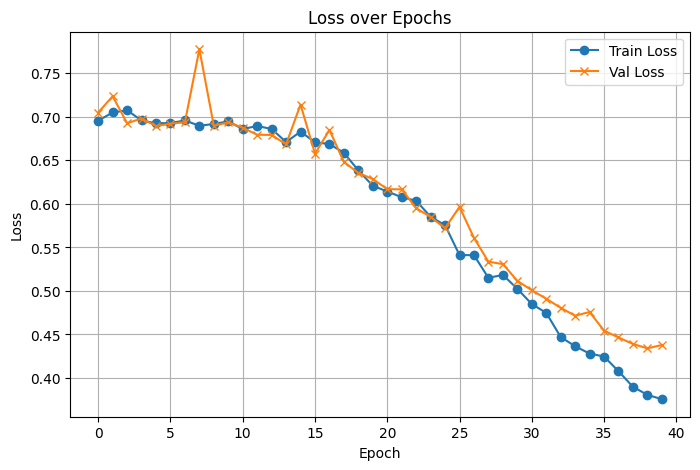

Epoch 40: train=0.3756, val=0.4379


In [73]:
N_EPOCH = 40
train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH + 1):
    perm = np.random.permutation(len(train_tokens))
    epoch_losses = []

    for i in range(0, len(perm), ft.batch_size):
        batch_idx    = perm[i : i + ft.batch_size]
        batch_toks   = [train_tokens[j] for j in batch_idx]
        batch_lbls   = train_labels[batch_idx]
        batch_df     = pd.DataFrame({"text": batch_toks, "label": batch_lbls})

        ft.backward(batch_df)
        epoch_losses.append(ft._loss_vals[-1])

    avg_train = float(np.mean(epoch_losses))
    train_losses.append(avg_train)

    val_df = pd.DataFrame({"text": val_tokens, "label": val_labels})
    vloss  = ft.eval(val_df)
    val_losses.append(vloss)

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses,   marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")

In [74]:
from collections import defaultdict
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]

ngram_scores = defaultdict(lambda: defaultdict(float))
ngram_counts = defaultdict(lambda: defaultdict(int))

for text in tqdm(train_texts, desc="Impact"):
    words      = tok._split(text)
    ngrams_lst = [tok._ngrams(wd) for wd in words]
    ids_lst    = tok.encode(text)

    for word, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        seen = set()
        for ng_str, idx in zip(ngrams, ids):
            if ng_str in seen: continue
            seen.add(ng_str)
            diff = ft.vocab[idx].dot(w_diff)
            key_ng = ng_str if tok.subword_mask[idx] else word
            ngram_scores[key_ng][word] += diff
            ngram_counts[key_ng][word] += 1

# pick the single most impactful word for each ngram
avg_impact = {}
for ng, wd_dict in ngram_scores.items():
    best_w, best_avg = max(
        ((w, s/ngram_counts[ng][w]) for w, s in wd_dict.items()),
        key=lambda x: abs(x[1])
    )
    avg_impact[f"{ng} ({best_w})"] = best_avg

# top 100 by absolute impact
top100 = sorted(avg_impact.items(), key=lambda x: -abs(x[1]))[:100]
for feat, sc in top100:
    print(f"{feat:>25s}: {sc:+.4f}")

Impact: 100%|██████████| 770/770 [00:05<00:00, 152.29it/s]


               <ma (make): -37.4887
             ers (buyers): -36.3928
ber (ofseveralcybersecurityprofessionalsandresearchersonxin): -36.3928
ver (althoughmedicarecovers): -36.3928
     ler (sotrspoilersdo): -36.3928
  ste (groupdjtregisters): -36.3928
            ger (joggers): -36.3928
her (pyramidsresearchers): -36.3928
        rer (flagbearers): -36.3928
         <te (technology): -34.5677
               <th (they): -31.4853
           tec (technica): -31.2466
              ch> (which): -30.9599
    mar (onzpeemnkamarch): -30.9599
          zic (frantzich): -30.9599
          ive (webdriver): +30.9407
     ove (viaoverclock3d): +30.9407
      ent (advertisement): +30.6725
    den (actingpresident): +30.6725
     cen (tvlinerecently): +30.6725
          erc (96percent): +30.6725
_ag (electrical_agent_594): +30.6725
           ech (technica): -30.4626
               er> (over): +30.1984
             ter (exeter): +30.1984
              ser (xuser): +30.1984
eaf (fromrctcxxbridgeafte